In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis
from scipy.stats import skew

sns.set()

In [ ]:
#Preprocessing and train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, Imputer

#Classifiers
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as ctb

#Cross validation
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


## Read and examine the data

I will use some visual EDA after examining it

In [ ]:
train = pd.read_csv("../input/X_train.csv")
test = pd.read_csv("../input/X_test.csv")
target = pd.read_csv("../input/y_train.csv")
sub = pd.read_csv("../input/sample_submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488448 entries, 0 to 488447
Data columns (total 13 columns):
row_id                   488448 non-null object
series_id                488448 non-null int64
measurement_number       488448 non-null int64
orientation_X            488448 non-null float64
orientation_Y            488448 non-null float64
orientation_Z            488448 non-null float64
orientation_W            488448 non-null float64
angular_velocity_X       488448 non-null float64
angular_velocity_Y       488448 non-null float64
angular_velocity_Z       488448 non-null float64
linear_acceleration_X    488448 non-null float64
linear_acceleration_Y    488448 non-null float64
linear_acceleration_Z    488448 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


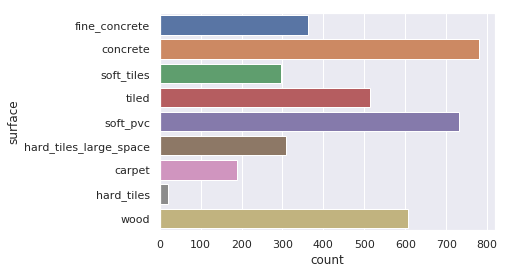

In [ ]:
sns.countplot(y = 'surface', data = target)

No missing data. But it looks like there is a huge variation in the types of surfaces in the target data. We must take that into account and stratify the target data for predictions.

## Correlation Heatmap:

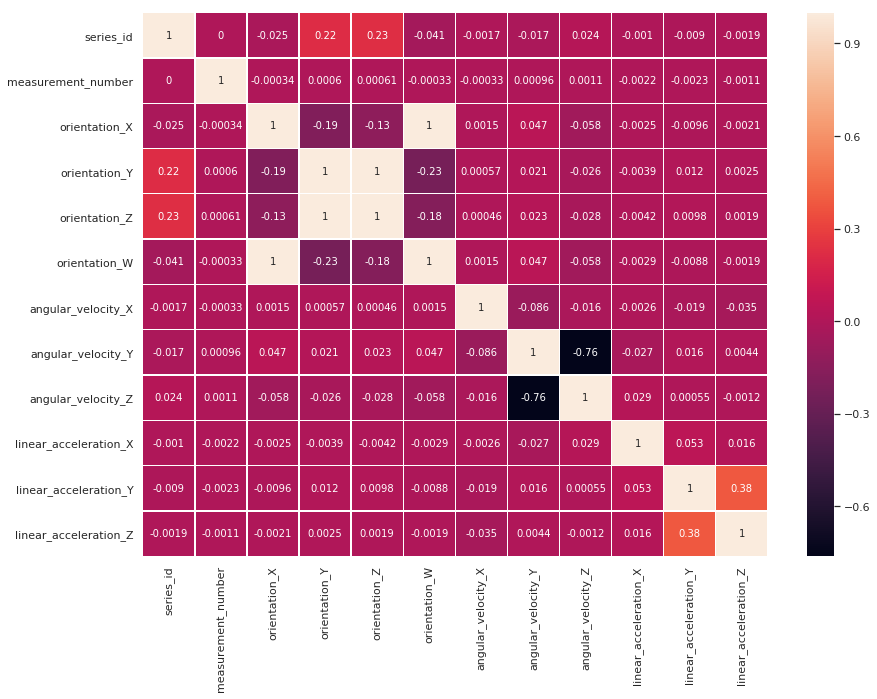

In [ ]:
corr = train.corr()

_ , ax = plt.subplots(figsize =(14, 10))
hm = sns.heatmap(corr, ax= ax, annot= True,linewidths=0.3)

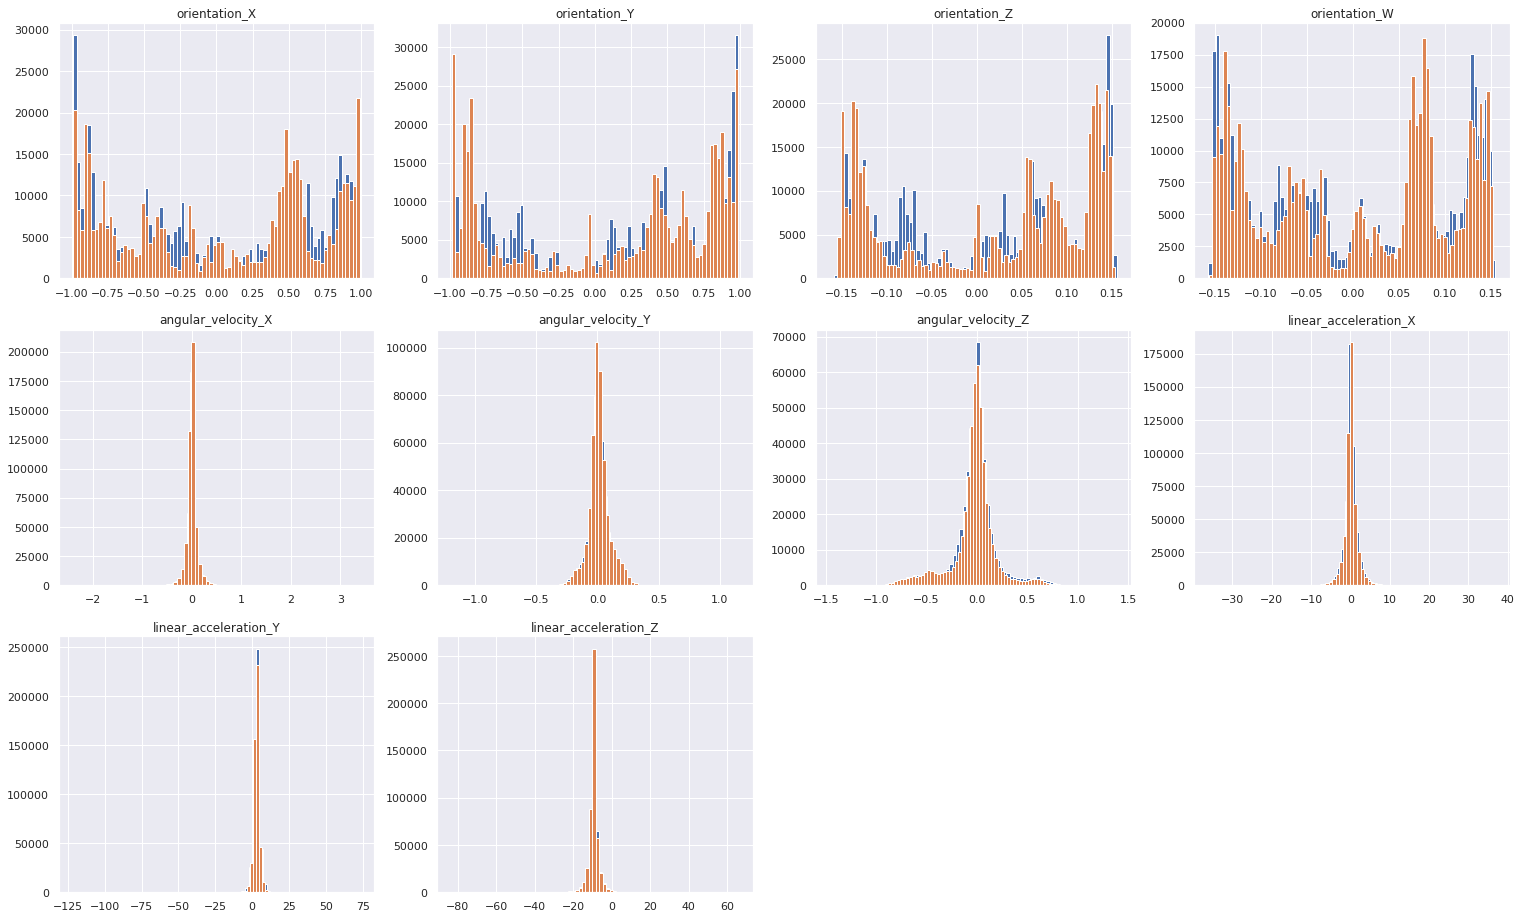

In [ ]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], bins=80)
    plt.hist(test[col], bins=80)
    plt.title(col)

Let's explore the data from the 10 channels for one particular series.

In [ ]:
def plotseries(df,series_id,color='Blue'):
    plt.figure(figsize=(26, 16))
    for i, col in enumerate(df.columns[3:]):
        plt.subplot(3, 4, i + 1)
        plt.plot(train.loc[train['series_id'] == series_id, col])
        plt.title(col)

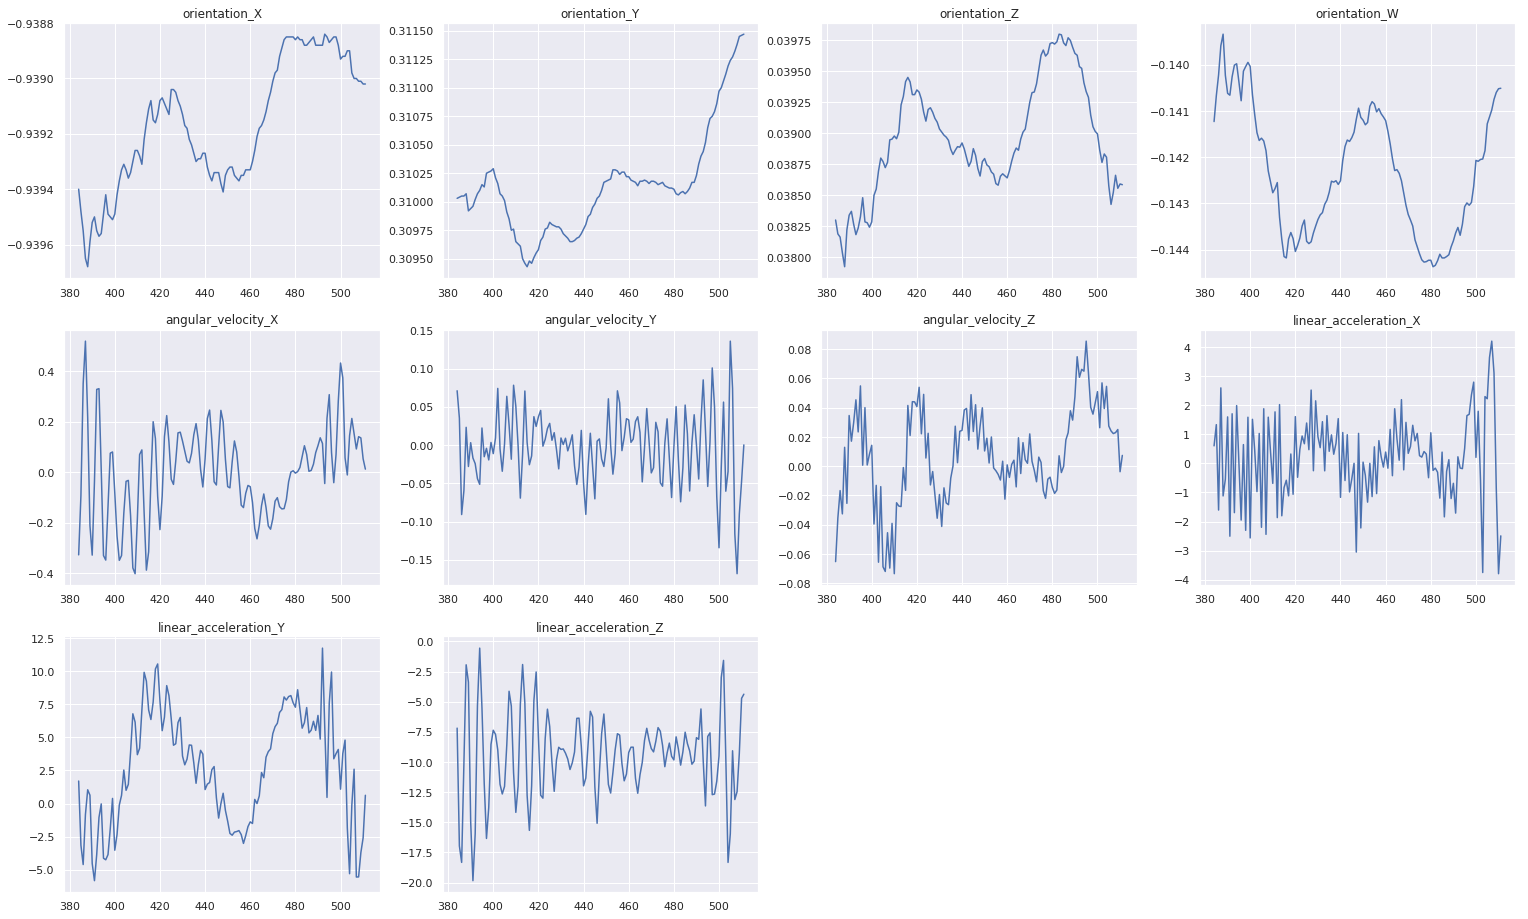

In [ ]:
plotseries(train,3)

Looks very noisy. We should probably denoise that before training models.

# Fast Fourier Transform (FFT)

I will smooth out the data by using fast fourier transform.

In [ ]:
from numpy.fft import rfft, irfft, rfftfreq

def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [ ]:
# denoise train and test angular_velocity and linear_acceleration data

train_denoised = train.copy()
test_denoised = test.copy()

# train
for col in train.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        # Apply filter_signal function to the data in each series
        denoised_data = train.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
        
        # Assign the denoised data back to X_train
        list_denoised_data = []
        for arr in denoised_data:
            for val in arr:
                list_denoised_data.append(val)
                
        train_denoised[col] = list_denoised_data
        
# test
for col in test.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        # Apply filter_signal function to the data in each series
        denoised_data = test.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
        
        # Assign the denoised data back to X_test
        list_denoised_data = []
        for arr in denoised_data:
            for val in arr:
                list_denoised_data.append(val)
                
        test_denoised[col] = list_denoised_data

Let's take a look at the denoised data for the 10 channels.

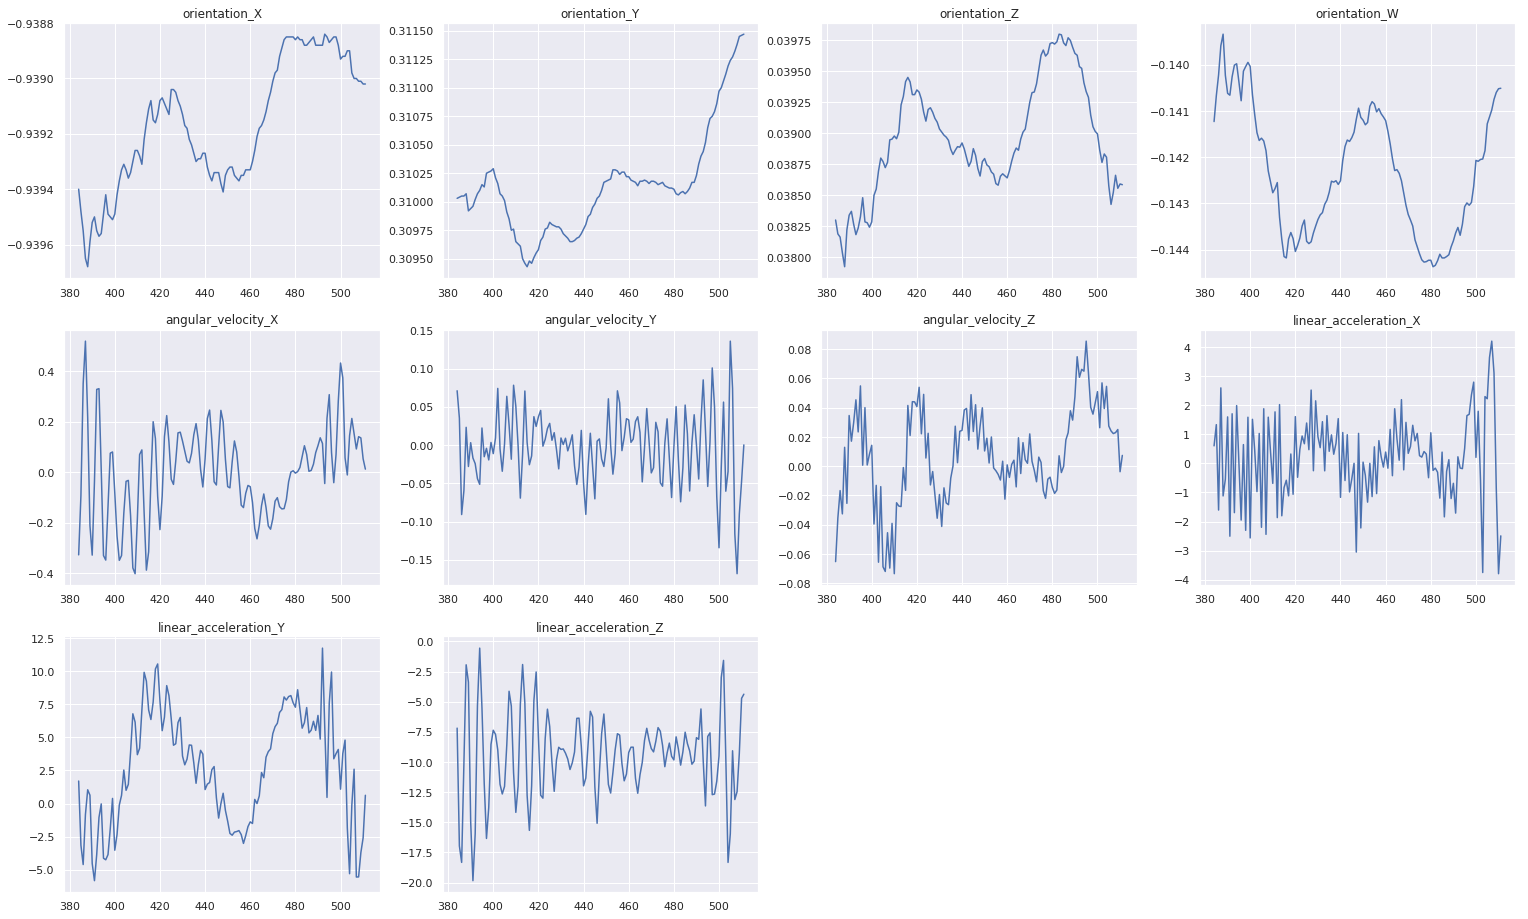

In [ ]:
plotseries(train_denoised,3)

Clearly it's hard to tell the difference from that. Let's take a closer look.

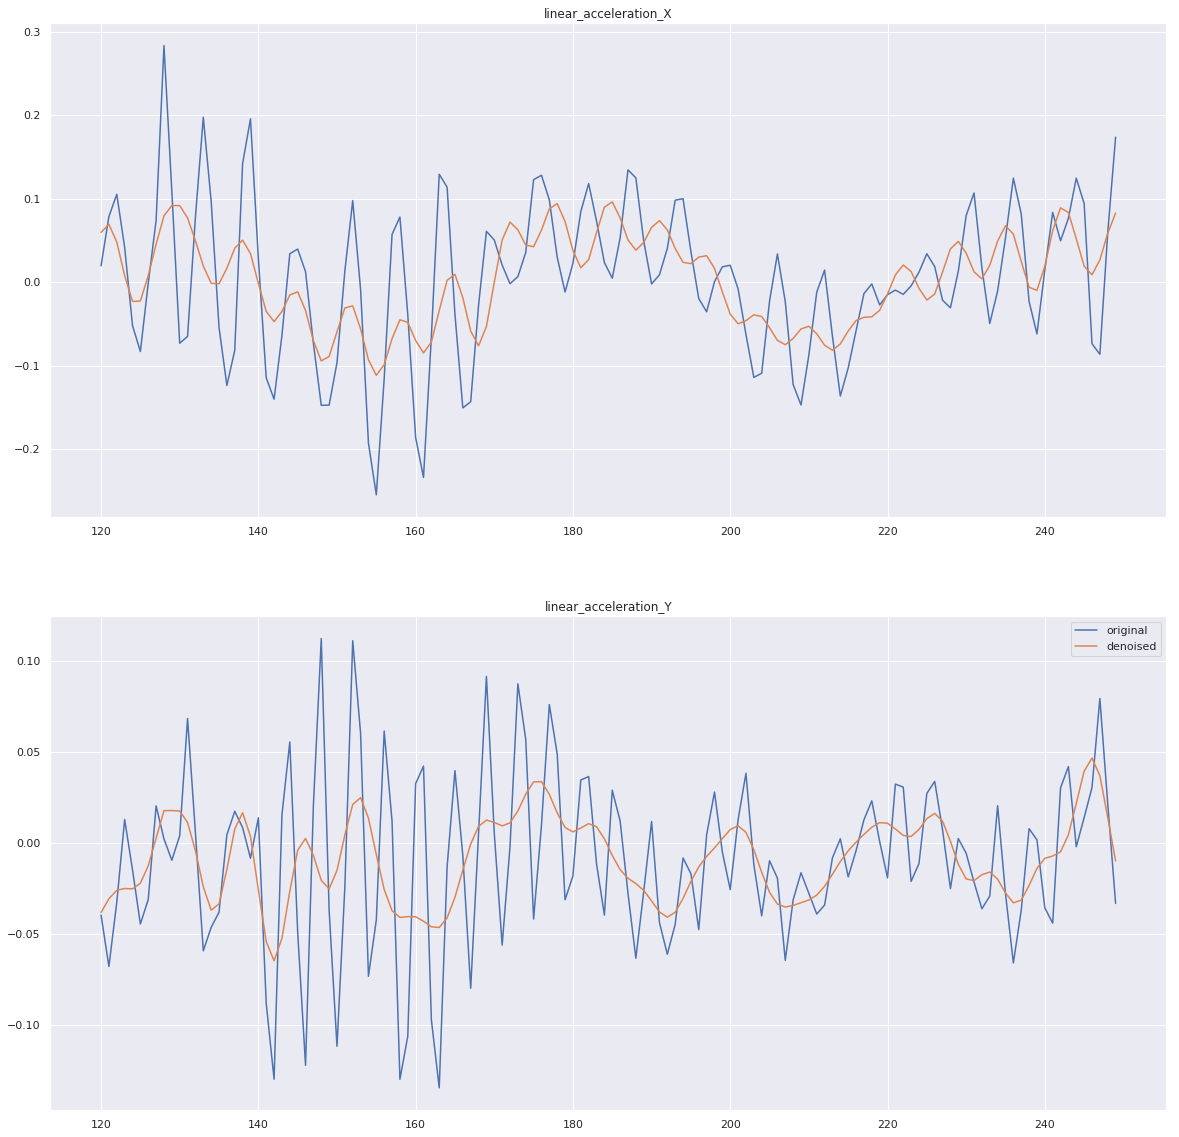

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.plot(train.angular_velocity_X[120:250], label="original");
plt.plot(train_denoised.angular_velocity_X[120:250], label="denoised");
plt.title('linear_acceleration_X')
plt.subplot(2,1,2)
plt.plot(train.angular_velocity_Y[120:250], label="original");
plt.plot(train_denoised.angular_velocity_Y[120:250], label="denoised");
plt.title('linear_acceleration_Y')
plt.legend()
plt.show()


All right, definitely made a difference.

# Feature Engineering



In [ ]:
for col in train.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        train_denoised[col + '_noise'] = np.abs(train[col] - train_denoised[col])
        
for col in test.columns:
    if col[0:3] == 'ang' or col[0:3] == 'lin':
        test_denoised[col + '_noise'] = np.abs(test[col] - test_denoised[col])
        


In [ ]:
"""I've used "https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
I do a coordinate transformation from quaternion to Euler" to convert quaternions to euler angles""" 

def quaternion_to_euler(x, y, z, w):

        import math
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = math.atan2(t0, t1)

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = math.asin(t2)

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = math.atan2(t3, t4)

        return X, Y, Z

def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))


In [ ]:
def feat(df):
      
    df['total_angular_velocity'] = (df['angular_velocity_X']**2+df['angular_velocity_Y']**2+df['angular_velocity_Z']**2)**0.5
    df['total_linear_acceleration'] = (df['linear_acceleration_X']**2+df['linear_acceleration_Y']**2+df['linear_acceleration_Z']**2)**0.5
    df['acc_vs_vel'] = df['total_linear_acceleration']/df['total_angular_velocity']
    
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    
    xlist, ylist, zlist = [], [], []
    
    for i in range(len(x)):
        x2, y2, z2 = quaternion_to_euler(x[i],y[i],z[i],w[i])
        xlist.append(x2)
        ylist.append(y2)
        zlist.append(z2)
    
    df['euler_X'] = xlist
    df['euler_Y'] = ylist
    df['euler_Z'] = zlist
    
    df['euler_orientation'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    
    def mean_diff(x):
        return np.mean(np.abs(np.diff(x)))
  
    def mean_diff_diff(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    df2 = pd.DataFrame()    
    
    for col in df.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        if 'noise' in col:
            df2[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        
        else:
            df2[col + '_mean'] = df.groupby(['series_id'])[col].mean()
            df2[col + '_min'] = df.groupby(['series_id'])[col].min()
            df2[col + '_max'] = df.groupby(['series_id'])[col].max()
            df2[col + '_std'] = df.groupby(['series_id'])[col].std()
            df2[col + '_range'] = df2[col + '_max'] - df2[col + '_min']
            df2[col + '_max_min_ratio'] = df.groupby(['series_id'])[col].max()/df.groupby(['series_id'])[col].min()
        
            df2[col + '_mean_abs_difference'] =df.groupby(['series_id'])[col].apply(mean_diff)
            df2[col + '_mean_diff_of_abs_diff'] = df.groupby('series_id')[col].apply(mean_diff_diff)
        
        
            df2[col + '_CPT5'] = df.groupby(['series_id'])[col].apply(CPT5) 
            df2[col + '_SSC'] = df.groupby(['series_id'])[col].apply(SSC) 
            df2[col + '_skewness'] = df.groupby(['series_id'])[col].apply(skewness)
            df2[col + '_wave_lenght'] = df.groupby(['series_id'])[col].apply(wave_length)
            df2[col + '_norm_entropy'] = df.groupby(['series_id'])[col].apply(norm_entropy)
            df2[col + '_SRAV'] = df.groupby(['series_id'])[col].apply(SRAV)
            df2[col + '_kurtosis'] = df.groupby(['series_id'])[col].apply(_kurtosis) 
            df2[col + '_mean_abs'] = df.groupby(['series_id'])[col].apply(mean_abs) 
            df2[col + '_zero_crossing'] = df.groupby(['series_id'])[col].apply(zero_crossing) 
        
        
        
    return df2
            

In [ ]:
train_fe = feat(train_denoised)
test_fe = feat(test_denoised)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


There are some NaN values and infinities, so we'll have to get rid of them. I will replace them with zeroes.

In [ ]:
train_fe.fillna(0,inplace=True)
test_fe.fillna(0,inplace=True)
train_fe.replace(-np.inf,0,inplace=True)
train_fe.replace(np.inf,0,inplace=True)
test_fe.replace(-np.inf,0,inplace=True)
test_fe.replace(np.inf,0,inplace=True)

## Preprocessing

I'm scaling the data and using a label encoder for the surdfaces.


In [ ]:
sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(train_fe))
X_test = pd.DataFrame(sc.transform(test_fe))

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [ ]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

## Plot Confusion Matrix:


In [ ]:
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title='Confusion Matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

# Models

Now we're ready to start building models and making predictions. I will start with Random forest. I have used grid search (in another Kernel) to extract the best parameters for it.

## Random Forest

In [ ]:
cv = 3
eval_list= []
pred_list = []
meas_list = []

for i in range (0,cv):

    folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=20)
    predicted_rf = np.zeros((X_test.shape[0],9))
    measured_rf= np.zeros((X_train.shape[0],9))
    score = 0
           
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,target['surface'].values)):
        
        X_tr = X_train.iloc[trn_idx]
        y_tr = target['surface'][trn_idx]
    
        X_valid = X_train.iloc[val_idx]
        y_valid = target['surface'][val_idx]
        
        rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf = 1,max_depth= None,n_jobs=-1,random_state=20)
        rfc.fit(X_tr,y_tr)
        measured_rf[val_idx] = rfc.predict_proba(X_valid)
        y_pred = rfc.predict_proba(X_test)
        predicted_rf += y_pred
        score += rfc.score(X_valid,y_valid)
        
        
        print("Fold: {}, RF Score: {}".format(fold,rfc.score(X_valid,y_valid)))
        
    predicted_rf /= folds.n_splits    
    
    meas_list.append(measured_rf)
    pred_list.append(predicted_rf)
    eval_list.append(score/folds.n_splits) 

Fold: 0, RF Score: 0.9251559251559252
Fold: 1, RF Score: 0.9020833333333333
Fold: 2, RF Score: 0.9331941544885177
Fold: 3, RF Score: 0.8951781970649895
Fold: 4, RF Score: 0.9136842105263158
Fold: 5, RF Score: 0.8985200845665962
Fold: 6, RF Score: 0.9133192389006343
Fold: 7, RF Score: 0.9322033898305084
Fold: 0, RF Score: 0.9251559251559252
Fold: 1, RF Score: 0.9020833333333333
Fold: 2, RF Score: 0.9331941544885177
Fold: 3, RF Score: 0.8951781970649895
Fold: 4, RF Score: 0.9136842105263158
Fold: 5, RF Score: 0.8985200845665962
Fold: 6, RF Score: 0.9133192389006343
Fold: 7, RF Score: 0.9322033898305084
Fold: 0, RF Score: 0.9251559251559252
Fold: 1, RF Score: 0.9020833333333333
Fold: 2, RF Score: 0.9331941544885177
Fold: 3, RF Score: 0.8951781970649895
Fold: 4, RF Score: 0.9136842105263158
Fold: 5, RF Score: 0.8985200845665962
Fold: 6, RF Score: 0.9133192389006343
Fold: 7, RF Score: 0.9322033898305084


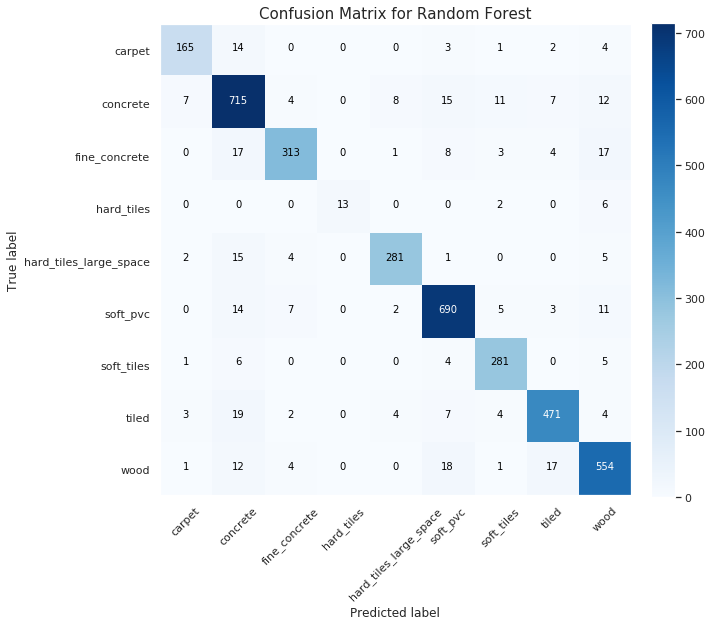

In [ ]:
plot_confusion_matrix(target['surface'], measured_rf.argmax(1), le.classes_,title ='Confusion Matrix for Random Forest')

In [ ]:
indx = eval_list.index(max(eval_list))
                      
print(indx, max(eval_list))
pred_rf = pred_list[indx]
meas_rf = meas_list[indx]

0 0.9141673167333525


In [ ]:
sub['surface'] = le.inverse_transform(pred_rf.argmax(1))
#sub.to_csv('submission_rf_fft.csv', index=False)
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles


In [ ]:
meas_rf.shape

(3810, 9)

## Extra Trees

In [ ]:
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=20)
predicted_et = np.zeros((X_test.shape[0],9))
measured_et = np.zeros((X_train.shape[0],9))
score_et = 0
           
for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,target['surface'].values)):
    
    X_tr = X_train.iloc[trn_idx]
    y_tr = target['surface'][trn_idx]
    
    X_valid = X_train.iloc[val_idx]
    y_valid = target['surface'][val_idx]
    
    
    etc = ExtraTreesClassifier(n_estimators=200,max_depth=12,min_samples_leaf=2,n_jobs=-1,random_state=20)
    etc.fit(X_tr,y_tr)
    measured_et[val_idx] = etc.predict_proba(X_valid)
    et_pred = etc.predict_proba(X_test)
    predicted_et += et_pred
    score_et += etc.score(X_valid,y_valid)/folds.n_splits
        
    print("Fold: {}, ET Score: {}".format(fold,etc.score(X_valid,y_valid)))
        
predicted_et /= folds.n_splits   

Fold: 0, ET Score: 0.918918918918919
Fold: 1, ET Score: 0.8916666666666667
Fold: 2, ET Score: 0.9144050104384134
Fold: 3, ET Score: 0.8825995807127882
Fold: 4, ET Score: 0.9052631578947369
Fold: 5, ET Score: 0.8879492600422833
Fold: 6, ET Score: 0.9069767441860465
Fold: 7, ET Score: 0.934322033898305


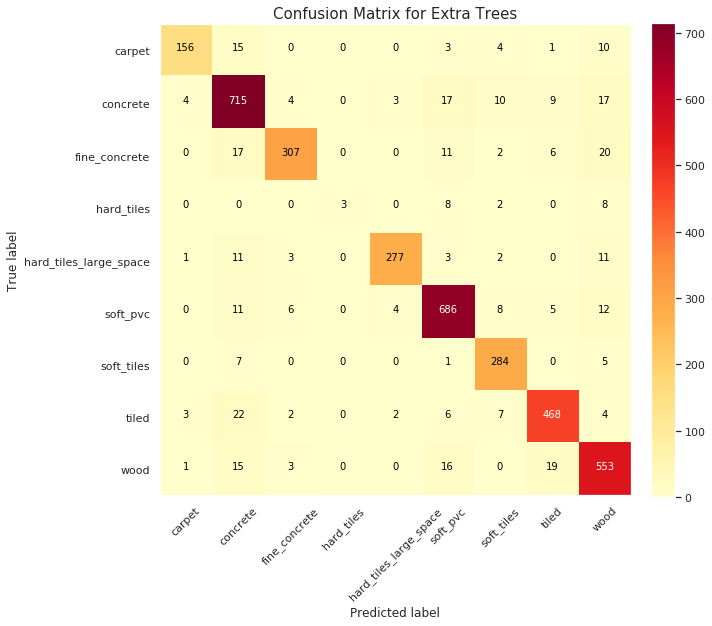

In [ ]:
plot_confusion_matrix(target['surface'], measured_et.argmax(1), le.classes_,title ='Confusion Matrix for Extra Trees',cmap=plt.cm.YlOrRd)

In [ ]:
measured_et.shape

(3810, 9)

## LightGBM

I'll also try LightGBM, the parameters for which I've extracted by using Bayesian Optimization.

In [ ]:
params_lgb = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'multiclass',
          'max_depth': 24,
          'learning_rate': 0.0468035094972387,
          "bagging_freq": 5,
          "bagging_fraction": 0.89330183551903,
          "bagging_seed": 11,
          "verbosity": 0,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.805849096054620,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.0099132272405649,
          'subsample': 0.90273588307031,
         }

In [ ]:
def fit_predict_lgb(X, X_tst, y, param=None):
    
    lgb_predicted = np.zeros((X_tst.shape[0],9))
    lgb_measured= np.zeros((X.shape[0],9))
    lgb_acc = 0
    
    feature_importance = pd.DataFrame()
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X,y)):
                
        lgbm = lgb.LGBMClassifier(**param, n_estimators = 20000, verbose = 0, n_jobs = -1,random_state=20,
                                  early_stopping_rounds=100)
        lgbm.fit(X.iloc[trn_idx],y[trn_idx], eval_set=[(X.iloc[trn_idx],y[trn_idx]), (X.iloc[val_idx],y[val_idx])], 
                 eval_metric='multi_logloss')
        lgb_measured[val_idx] = lgbm.predict_proba(X.iloc[val_idx])
        y_pred = lgbm.predict_proba(X_tst)/folds.n_splits
        lgb_predicted +=y_pred
        lgb_acc += accuracy_score(y[val_idx], lgb_measured[val_idx].argmax(1))/folds.n_splits
    
        print("Fold: {} LGB score: {}".format(fold,accuracy_score(y[val_idx], lgb_measured[val_idx].argmax(1))))
        
       
    return lgb_measured, lgb_predicted, lgb_acc


In [ ]:
measured_lgb, predicted_lgb, score_lgb = fit_predict_lgb(X_train,X_test,target['surface'], param=params_lgb)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.8767	valid_0's multi_logloss: 1.8767	valid_1's multi_logloss: 1.89833	valid_1's multi_logloss: 1.89833
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76448	valid_0's multi_logloss: 1.76448	valid_1's multi_logloss: 1.80144	valid_1's multi_logloss: 1.80144
[3]	valid_0's multi_logloss: 1.66713	valid_0's multi_logloss: 1.66713	valid_1's multi_logloss: 1.7142	valid_1's multi_logloss: 1.7142
[4]	valid_0's multi_logloss: 1.57972	valid_0's multi_logloss: 1.57972	valid_1's multi_logloss: 1.63765	valid_1's multi_logloss: 1.63765
[5]	valid_0's multi_logloss: 1.50181	valid_0's multi_logloss: 1.50181	valid_1's multi_logloss: 1.57022	valid_1's multi_logloss: 1.57022
[6]	valid_0's multi_logloss: 1.43044	valid_0's multi_logloss: 1.43044	valid_1's multi_logloss: 1.50692	valid_1's multi_logloss: 1.50692
[7]	valid_0's multi_logloss: 1.36543	valid_0's multi_logloss: 1.36543	valid_1's multi_logloss: 1.44899	valid_1's multi_loglos

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.8748	valid_0's multi_logloss: 1.8748	valid_1's multi_logloss: 1.89704	valid_1's multi_logloss: 1.89704
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76151	valid_0's multi_logloss: 1.76151	valid_1's multi_logloss: 1.80262	valid_1's multi_logloss: 1.80262
[3]	valid_0's multi_logloss: 1.66335	valid_0's multi_logloss: 1.66335	valid_1's multi_logloss: 1.7215	valid_1's multi_logloss: 1.7215
[4]	valid_0's multi_logloss: 1.5764	valid_0's multi_logloss: 1.5764	valid_1's multi_logloss: 1.64899	valid_1's multi_logloss: 1.64899
[5]	valid_0's multi_logloss: 1.4981	valid_0's multi_logloss: 1.4981	valid_1's multi_logloss: 1.58354	valid_1's multi_logloss: 1.58354
[6]	valid_0's multi_logloss: 1.42635	valid_0's multi_logloss: 1.42635	valid_1's multi_logloss: 1.52489	valid_1's multi_logloss: 1.52489
[7]	valid_0's multi_logloss: 1.36122	valid_0's multi_logloss: 1.36122	valid_1's multi_logloss: 1.47072	valid_1's multi_logloss: 1

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87808	valid_0's multi_logloss: 1.87808	valid_1's multi_logloss: 1.90008	valid_1's multi_logloss: 1.90008
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.7675	valid_0's multi_logloss: 1.7675	valid_1's multi_logloss: 1.80306	valid_1's multi_logloss: 1.80306
[3]	valid_0's multi_logloss: 1.66912	valid_0's multi_logloss: 1.66912	valid_1's multi_logloss: 1.71477	valid_1's multi_logloss: 1.71477
[4]	valid_0's multi_logloss: 1.58226	valid_0's multi_logloss: 1.58226	valid_1's multi_logloss: 1.63514	valid_1's multi_logloss: 1.63514
[5]	valid_0's multi_logloss: 1.5046	valid_0's multi_logloss: 1.5046	valid_1's multi_logloss: 1.56607	valid_1's multi_logloss: 1.56607
[6]	valid_0's multi_logloss: 1.43181	valid_0's multi_logloss: 1.43181	valid_1's multi_logloss: 1.50398	valid_1's multi_logloss: 1.50398
[7]	valid_0's multi_logloss: 1.366	valid_0's multi_logloss: 1.366	valid_1's multi_logloss: 1.44645	valid_1's multi_logloss: 1

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87895	valid_0's multi_logloss: 1.87895	valid_1's multi_logloss: 1.90138	valid_1's multi_logloss: 1.90138
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76747	valid_0's multi_logloss: 1.76747	valid_1's multi_logloss: 1.80775	valid_1's multi_logloss: 1.80775
[3]	valid_0's multi_logloss: 1.66993	valid_0's multi_logloss: 1.66993	valid_1's multi_logloss: 1.72571	valid_1's multi_logloss: 1.72571
[4]	valid_0's multi_logloss: 1.58385	valid_0's multi_logloss: 1.58385	valid_1's multi_logloss: 1.65321	valid_1's multi_logloss: 1.65321
[5]	valid_0's multi_logloss: 1.5053	valid_0's multi_logloss: 1.5053	valid_1's multi_logloss: 1.58923	valid_1's multi_logloss: 1.58923
[6]	valid_0's multi_logloss: 1.43192	valid_0's multi_logloss: 1.43192	valid_1's multi_logloss: 1.52822	valid_1's multi_logloss: 1.52822
[7]	valid_0's multi_logloss: 1.36496	valid_0's multi_logloss: 1.36496	valid_1's multi_logloss: 1.47337	valid_1's multi_logl

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87891	valid_0's multi_logloss: 1.87891	valid_1's multi_logloss: 1.89571	valid_1's multi_logloss: 1.89571
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76869	valid_0's multi_logloss: 1.76869	valid_1's multi_logloss: 1.79846	valid_1's multi_logloss: 1.79846
[3]	valid_0's multi_logloss: 1.67123	valid_0's multi_logloss: 1.67123	valid_1's multi_logloss: 1.7105	valid_1's multi_logloss: 1.7105
[4]	valid_0's multi_logloss: 1.58523	valid_0's multi_logloss: 1.58523	valid_1's multi_logloss: 1.63299	valid_1's multi_logloss: 1.63299
[5]	valid_0's multi_logloss: 1.50791	valid_0's multi_logloss: 1.50791	valid_1's multi_logloss: 1.56309	valid_1's multi_logloss: 1.56309
[6]	valid_0's multi_logloss: 1.43574	valid_0's multi_logloss: 1.43574	valid_1's multi_logloss: 1.50084	valid_1's multi_logloss: 1.50084
[7]	valid_0's multi_logloss: 1.36979	valid_0's multi_logloss: 1.36979	valid_1's multi_logloss: 1.44413	valid_1's multi_logl

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87761	valid_0's multi_logloss: 1.87761	valid_1's multi_logloss: 1.88886	valid_1's multi_logloss: 1.88886
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76608	valid_0's multi_logloss: 1.76608	valid_1's multi_logloss: 1.79778	valid_1's multi_logloss: 1.79778
[3]	valid_0's multi_logloss: 1.66889	valid_0's multi_logloss: 1.66889	valid_1's multi_logloss: 1.71709	valid_1's multi_logloss: 1.71709
[4]	valid_0's multi_logloss: 1.58088	valid_0's multi_logloss: 1.58088	valid_1's multi_logloss: 1.64442	valid_1's multi_logloss: 1.64442
[5]	valid_0's multi_logloss: 1.50251	valid_0's multi_logloss: 1.50251	valid_1's multi_logloss: 1.58141	valid_1's multi_logloss: 1.58141
[6]	valid_0's multi_logloss: 1.43089	valid_0's multi_logloss: 1.43089	valid_1's multi_logloss: 1.52418	valid_1's multi_logloss: 1.52418
[7]	valid_0's multi_logloss: 1.36552	valid_0's multi_logloss: 1.36552	valid_1's multi_logloss: 1.47155	valid_1's multi_lo

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87883	valid_0's multi_logloss: 1.87883	valid_1's multi_logloss: 1.89078	valid_1's multi_logloss: 1.89078
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76741	valid_0's multi_logloss: 1.76741	valid_1's multi_logloss: 1.79435	valid_1's multi_logloss: 1.79435
[3]	valid_0's multi_logloss: 1.66969	valid_0's multi_logloss: 1.66969	valid_1's multi_logloss: 1.70744	valid_1's multi_logloss: 1.70744
[4]	valid_0's multi_logloss: 1.58249	valid_0's multi_logloss: 1.58249	valid_1's multi_logloss: 1.62903	valid_1's multi_logloss: 1.62903
[5]	valid_0's multi_logloss: 1.50398	valid_0's multi_logloss: 1.50398	valid_1's multi_logloss: 1.55926	valid_1's multi_logloss: 1.55926
[6]	valid_0's multi_logloss: 1.43173	valid_0's multi_logloss: 1.43173	valid_1's multi_logloss: 1.49739	valid_1's multi_logloss: 1.49739
[7]	valid_0's multi_logloss: 1.36532	valid_0's multi_logloss: 1.36532	valid_1's multi_logloss: 1.44036	valid_1's multi_lo

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.87995	valid_0's multi_logloss: 1.87995	valid_1's multi_logloss: 1.89004	valid_1's multi_logloss: 1.89004
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.76974	valid_0's multi_logloss: 1.76974	valid_1's multi_logloss: 1.79558	valid_1's multi_logloss: 1.79558
[3]	valid_0's multi_logloss: 1.67305	valid_0's multi_logloss: 1.67305	valid_1's multi_logloss: 1.71019	valid_1's multi_logloss: 1.71019
[4]	valid_0's multi_logloss: 1.58574	valid_0's multi_logloss: 1.58574	valid_1's multi_logloss: 1.63243	valid_1's multi_logloss: 1.63243
[5]	valid_0's multi_logloss: 1.50739	valid_0's multi_logloss: 1.50739	valid_1's multi_logloss: 1.56363	valid_1's multi_logloss: 1.56363
[6]	valid_0's multi_logloss: 1.43613	valid_0's multi_logloss: 1.43613	valid_1's multi_logloss: 1.50251	valid_1's multi_logloss: 1.50251
[7]	valid_0's multi_logloss: 1.37098	valid_0's multi_logloss: 1.37098	valid_1's multi_logloss: 1.44598	valid_1's multi_lo

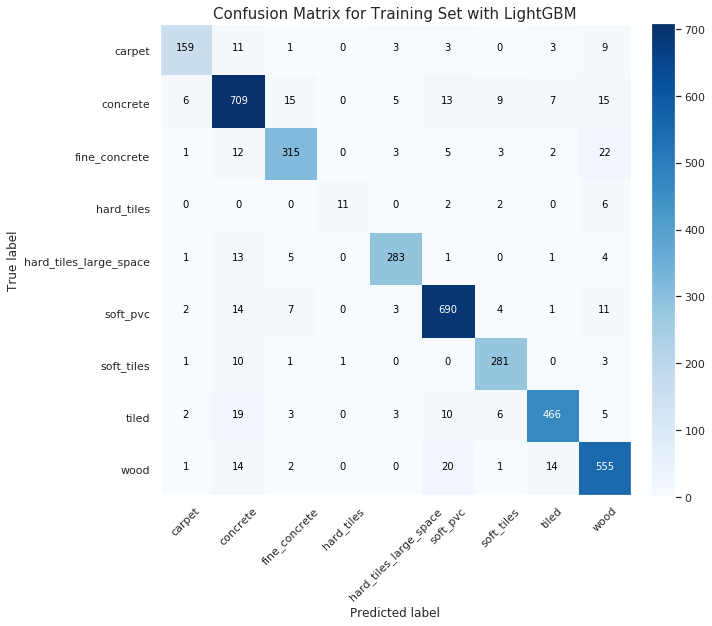

In [ ]:
plot_confusion_matrix(target['surface'], measured_lgb.argmax(1),le.classes_, title ='Confusion Matrix for Training Set with LightGBM',)

## SVC

SVC is also something to try. I used Grid Search to find the best parameters for SVC, then use that to fit the test data. It won't be as accurate as random forest, but it doesn't hurt to check.

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)
svc_predicted = np.zeros((X_test.shape[0],9))
svc_measured= np.zeros((X_train.shape[0]))
svc_score = 0
svc_acc = []
svc = SVC(random_state=314,C=1, decision_function_shape= 'ovo', gamma= 'auto',max_iter= -1, probability=True)

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,target['surface'].values)):

    X_tr = X_train.iloc[trn_idx]
    y_tr = target['surface'][trn_idx]
        
    X_valid= X_train.iloc[val_idx]
    y_valid = target['surface'][val_idx]
    
    
    svc.fit(X_tr,y_tr)
    svc_measured[val_idx] = svc.predict(X_valid)
    svc_score += svc.score(X_valid,y_valid)/folds.n_splits
    
    svc_pred = svc.predict_proba(X_test)
    svc_predicted += svc_pred
    
    svc_acc.append(svc_score)
    
    print("Fold: {}, SVC Score: {}".format(fold,svc.score(X_valid,y_valid)))
    
svc_predicted /= folds.n_splits

Fold: 0, SVC Score: 0.8337662337662337
Fold: 1, SVC Score: 0.7864583333333334
Fold: 2, SVC Score: 0.825065274151436
Fold: 3, SVC Score: 0.8141361256544503
Fold: 4, SVC Score: 0.7874015748031497
Fold: 5, SVC Score: 0.8188976377952756
Fold: 6, SVC Score: 0.821522309711286
Fold: 7, SVC Score: 0.8126649076517151
Fold: 8, SVC Score: 0.8068783068783069
Fold: 9, SVC Score: 0.851063829787234


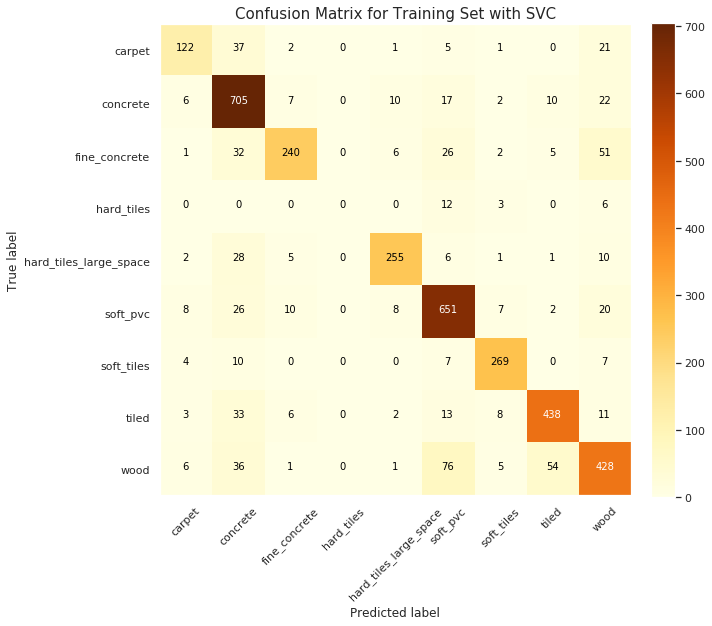

In [ ]:
plot_confusion_matrix(target['surface'],svc_measured,le.classes_, title ='Confusion Matrix for Training Set with SVC',cmap=plt.cm.YlOrBr)

SVC isn't doing very well, so I won't use it for stacking.

# Stacking:

I will use Logistic Regression as the meta classifier built on Random Forest, Extra Trees and LightGBM first. 

In [ ]:
x_train = np.concatenate((measured_et, meas_rf, measured_lgb), axis=1)
x_test = np.concatenate((predicted_et, pred_rf, predicted_lgb), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

(3810, 27),(3816, 27)


In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,target['surface'])

logreg_pred = logistic_regression.predict_proba(x_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Submission

In [ ]:
sub['surface'] = le.inverse_transform(logreg_pred.argmax(1))
#sub.to_csv('submission_lr_stack.csv', index=False)
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles
